# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #2

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


# Introduction

Tout d'abord, avant de commencer le TP, nous importons et initialisons quelques aides.

À noter que nous avons du augmenter la limite de récursion de python à 30000 avec `sys.setrecursionlimit(30000)`, car certains arbres WordPress étaient trop grands. Ceci servira pour l'exercice 2.

In [1]:
import sys
import tempfile
from collections import defaultdict
from pathlib import Path

from code_analysis import AST, CFG, ASTReader, CFGReader, Graph
from graphviz.sources import Source
from IPython.display import Image

sys.setrecursionlimit(30000)

ast_reader = ASTReader()
cfg_reader = CFGReader()


def show_graph(graph: Graph):
    dot = graph.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        display(Image(f.name + ".png"))

# 1. Construction du CFG

Pour les CFG, nous avons fait le choix de retirer entièrement le contexte global et de recréer le visiteur d'exemple. Ceci permet d'éviter beaucoup de bugs selon nous qui rendaient le débuggage difficile. Tous les exemples ont donc pu être implémentés sans utilisation de contexte.

In [2]:
class ASTtoCFGVisitor:
    def __init__(self, ast: AST):
        self.ast = ast
        self.cfg = CFG()
        self.curr_nid = 0

        self.handlers = {
            "FunctionCall": self.visit_funccall,
            "BinOP": self.visit_binop,
            "Variable": self.visit_variable,
            "IfThenElseStatement": self.visit_ifelse,
            "Condition": self.visit_condition,
            "RelOP": self.visit_relop,
            "StatementBody": self.visit_statementbody,
            "Block": self.iter_children,
            "While": self.visit_while,
            "IfThenStatement": self.visit_if,
            "Argument": self.visit_argument,
            "Continue": self.visit_continue,
            "Break": self.visit_break,
        }

    def get_new_nid(self) -> int:
        self.curr_nid += 1
        return self.curr_nid

    @classmethod
    def visit(cls, ast: AST) -> CFG:
        visitor = cls(ast)
        print(f"Visit AST from file {visitor.ast.get_filename()}")
        visitor.visit_root(ast.get_root())
        return visitor.cfg

    def visit_root(self, ast_nid: int) -> int | None:
        entry_nid = self.get_new_nid()
        self.cfg.set_root(entry_nid)
        self.cfg.set_type(entry_nid, "Entry")
        self.cfg.set_image(entry_nid, "main")
        self.cfg.set_node_ptr(ast_nid, entry_nid)

        exit_nid = self.get_new_nid()
        self.cfg.set_type(exit_nid, "Exit")

        last_child_nid = self.iter_children(ast_nid, entry_nid, entry_nid, exit_nid)
        assert last_child_nid is not None
        self.cfg.add_edge(last_child_nid, exit_nid)

        return exit_nid

    def iter_children(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        children = self.ast.get_children(ast_nid)
        new_parent_nid = parent_nid
        for child_node in children:
            new_parent_nid = self.visit_node(
                child_node, new_parent_nid, block_start_nid, block_end_nid
            )
        return new_parent_nid

    def visit_node(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        node_type = self.ast.get_type(ast_nid)
        # print(f"Visiting node {ast_nid} ({node_type}) with parent {parent_nid}")
        # display(show_cfg(self.cfg))
        handler = self.handlers.get(node_type, self.visit_generic)
        return handler(ast_nid, parent_nid, block_start_nid, block_end_nid)

    def visit_generic(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        print(f"Generic visit for {self.ast.get_type(ast_nid)}")
        nid = self.get_new_nid()
        self.cfg.set_type(nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, nid)

        last_child_nid = self.iter_children(
            ast_nid, nid, block_start_nid, block_end_nid
        )

        return last_child_nid

    def visit_funccall(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        funccall_nid = self.get_new_nid()
        self.cfg.set_type(funccall_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(funccall_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, funccall_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, funccall_nid)

        callbegin_nid = self.get_new_nid()
        self.cfg.set_type(callbegin_nid, "CallBegin")
        self.cfg.set_image(callbegin_nid, self.ast.get_image(ast_nid))

        callend_nid = self.get_new_nid()
        self.cfg.set_type(callend_nid, "CallEnd")
        self.cfg.set_image(callend_nid, self.ast.get_image(ast_nid))

        self.cfg.set_call(callbegin_nid, callend_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        id_node, arglist_node = children[0], children[1]

        id_cfg_nid = self.visit_node(
            id_node, funccall_nid, block_start_nid, block_end_nid
        )
        assert id_cfg_nid is not None
        self.cfg.set_call_expr(callbegin_nid, id_cfg_nid)

        arglist_nid = self.get_new_nid()
        self.cfg.set_type(arglist_nid, self.ast.get_type(arglist_node))
        self.cfg.set_node_ptr(arglist_node, arglist_nid)

        self.cfg.add_edge(id_cfg_nid, arglist_nid)

        args_nodes = self.ast.get_children(arglist_node)
        new_parent_nid = arglist_nid
        for arg_node in args_nodes:
            new_parent_nid = self.visit_node(
                arg_node, new_parent_nid, block_start_nid, block_end_nid
            )
            assert new_parent_nid is not None
            self.cfg.add_call_arg(callbegin_nid, new_parent_nid)

        self.cfg.add_edge(new_parent_nid, callbegin_nid)

        retval_nid = self.get_new_nid()
        self.cfg.set_type(retval_nid, "RetValue")

        self.cfg.add_edge(callend_nid, retval_nid)

        return retval_nid

    def visit_binop(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        binop_nid = self.get_new_nid()
        self.cfg.set_type(binop_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(binop_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, binop_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        var_node, val_node = children[0], children[1]

        val_cfg_id = self.visit_node(
            val_node, parent_nid, block_start_nid, block_end_nid
        )
        var_cfg_id = self.visit_node(
            var_node, val_cfg_id, block_start_nid, block_end_nid
        )
        assert var_cfg_id is not None
        assert val_cfg_id is not None

        self.cfg.add_edge(var_cfg_id, binop_nid)
        self.cfg.set_op_hands(binop_nid, var_cfg_id, val_cfg_id)

        return binop_nid

    def visit_variable(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        nid = self.visit_generic(ast_nid, parent_nid, block_start_nid, block_end_nid)
        assert nid is not None
        self.cfg.set_var_id(nid, self.ast.get_var_id(ast_nid))
        self.cfg.set_var_scope(nid, self.ast.get_var_scope(ast_nid))
        return nid

    def visit_ifelse(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        if_nid = self.get_new_nid()
        self.cfg.set_type(if_nid, "If")
        self.cfg.set_node_ptr(ast_nid, if_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, if_nid)

        end_nid = self.get_new_nid()
        self.cfg.set_type(end_nid, "IfEnd")

        children = self.ast.get_children(ast_nid)
        assert len(children) == 3
        cond_node, then_node, else_node = children[0], children[1], children[2]

        cond_cfg_nid = self.visit_node(
            cond_node, if_nid, block_start_nid, block_end_nid
        )
        then_cfg_nid = self.visit_node(
            then_node, cond_cfg_nid, block_start_nid, block_end_nid
        )
        else_cfg_nid = self.visit_node(
            else_node, cond_cfg_nid, block_start_nid, block_end_nid
        )
        assert then_cfg_nid is not None
        assert else_cfg_nid is not None

        self.cfg.add_edge(then_cfg_nid, end_nid)
        self.cfg.add_edge(else_cfg_nid, end_nid)

        return end_nid

    def visit_condition(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        rel_node = children[0]

        rel_cfg_nid = self.visit_node(
            rel_node, parent_nid, block_start_nid, block_end_nid
        )
        assert rel_cfg_nid is not None

        cond_nid = self.get_new_nid()
        self.cfg.set_type(cond_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, cond_nid)

        self.cfg.add_edge(rel_cfg_nid, cond_nid)

        return cond_nid

    def visit_relop(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        relop_nid = self.get_new_nid()
        self.cfg.set_type(relop_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(relop_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, relop_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        left_node, right_node = children[0], children[1]

        left_cfg_id = self.visit_node(
            left_node, parent_nid, block_start_nid, block_end_nid
        )
        right_cfg_id = self.visit_node(
            right_node, left_cfg_id, block_start_nid, block_end_nid
        )
        assert left_cfg_id is not None
        assert right_cfg_id is not None

        self.cfg.add_call_arg(relop_nid, left_cfg_id)
        self.cfg.add_call_arg(relop_nid, right_cfg_id)

        self.cfg.add_edge(right_cfg_id, relop_nid)

        return relop_nid

    def visit_statementbody(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        block_node = children[0]
        return self.visit_node(block_node, parent_nid, block_start_nid, block_end_nid)

    def visit_while(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        while_nid = self.get_new_nid()
        self.cfg.set_type(while_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, while_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, while_nid)

        while_end_nid = self.get_new_nid()
        self.cfg.set_type(while_end_nid, "WhileEnd")

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        cond_node, block_node = children[0], children[1]

        cond_cfg_nid = self.visit_node(
            cond_node, while_nid, block_start_nid, block_end_nid
        )
        block_cfg_nid = self.visit_node(
            block_node, cond_cfg_nid, while_nid, while_end_nid
        )
        assert cond_cfg_nid is not None
        assert block_cfg_nid is not None

        self.cfg.add_edge(block_cfg_nid, while_nid)
        self.cfg.add_edge(cond_cfg_nid, while_end_nid)

        return while_end_nid

    def visit_if(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        if_nid = self.get_new_nid()
        self.cfg.set_type(if_nid, "If")
        self.cfg.set_node_ptr(ast_nid, if_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, if_nid)

        end_nid = self.get_new_nid()
        self.cfg.set_type(end_nid, "IfEnd")

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        cond_node, then_node = children[0], children[1]

        cond_cfg_nid = self.visit_node(
            cond_node, if_nid, block_start_nid, block_end_nid
        )
        assert cond_cfg_nid is not None
        self.cfg.add_edge(cond_cfg_nid, end_nid)

        then_cfg_nid = self.visit_node(
            then_node, cond_cfg_nid, block_start_nid, block_end_nid
        )
        if then_cfg_nid is not None:
            self.cfg.add_edge(then_cfg_nid, end_nid)

        return end_nid

    def visit_argument(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        arg_nid = self.get_new_nid()
        self.cfg.set_type(arg_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, arg_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        arg_val_node = children[0]

        arg_val_nid = self.visit_node(
            arg_val_node, parent_nid, block_start_nid, block_end_nid
        )
        assert arg_val_nid is not None
        self.cfg.add_edge(arg_val_nid, arg_nid)

        return arg_nid

    def visit_continue(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        continue_nid = self.get_new_nid()
        self.cfg.set_type(continue_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, continue_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, continue_nid)

        self.cfg.add_edge(continue_nid, block_start_nid)
        return None

    def visit_break(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        break_nid = self.get_new_nid()
        self.cfg.set_type(break_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, break_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, break_nid)

        self.cfg.add_edge(break_nid, block_end_nid)
        return None

## Exemple 1 - FunctionCall

Visit AST from file code.php
Generic visit for Id
Generic visit for StringLiteral


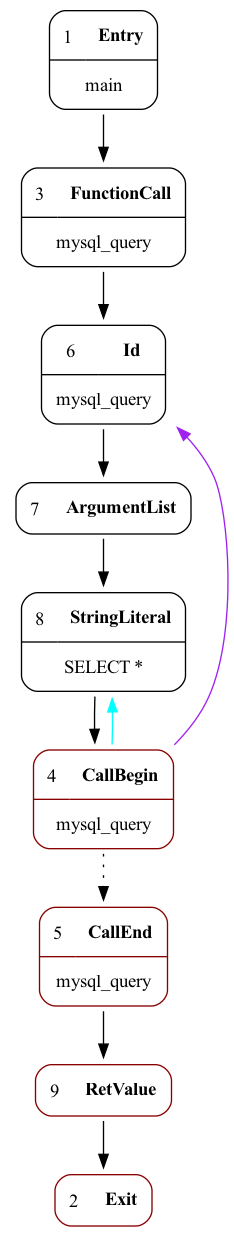

In [3]:
ast = ast_reader.read_ast("../part_1/functioncall/functioncall.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_graph(cfg)

## Exemple 2 - If

Visit AST from file code.php
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression


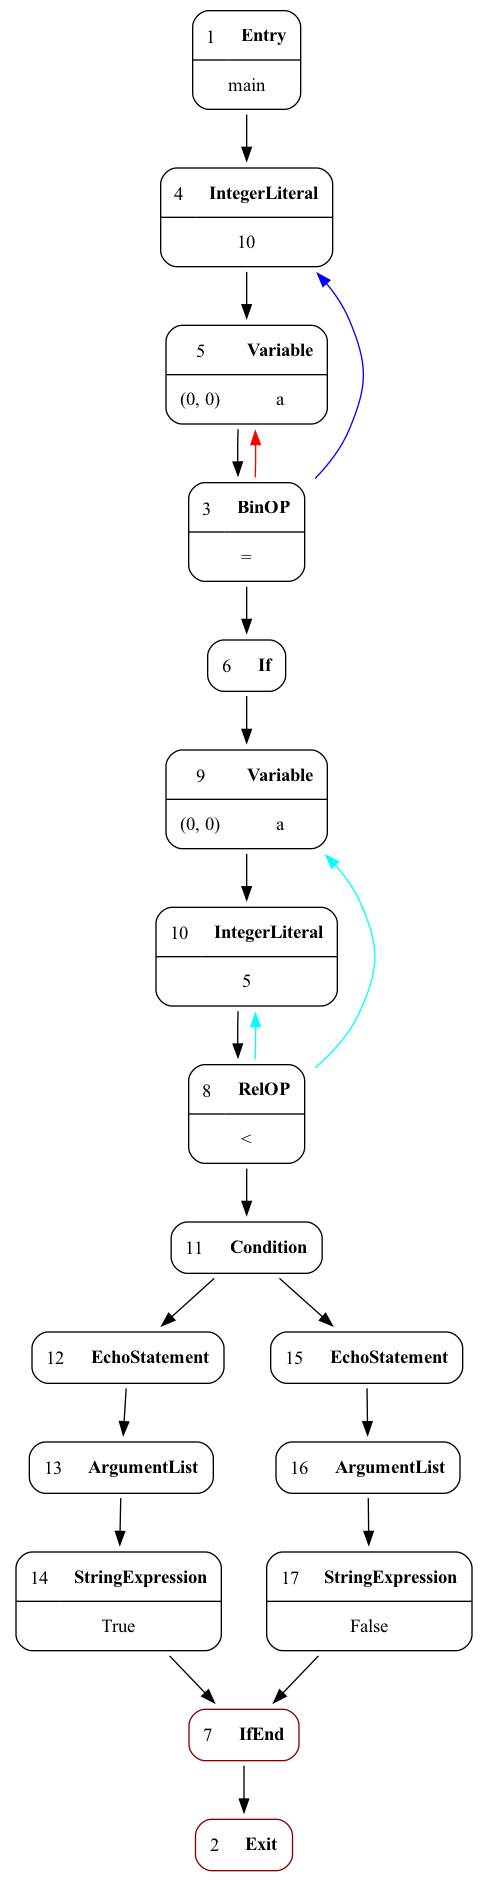

In [4]:
ast = ast_reader.read_ast("../part_1/if/if.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_graph(cfg)

## Exemple 3 - While

Visit AST from file code.php
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression


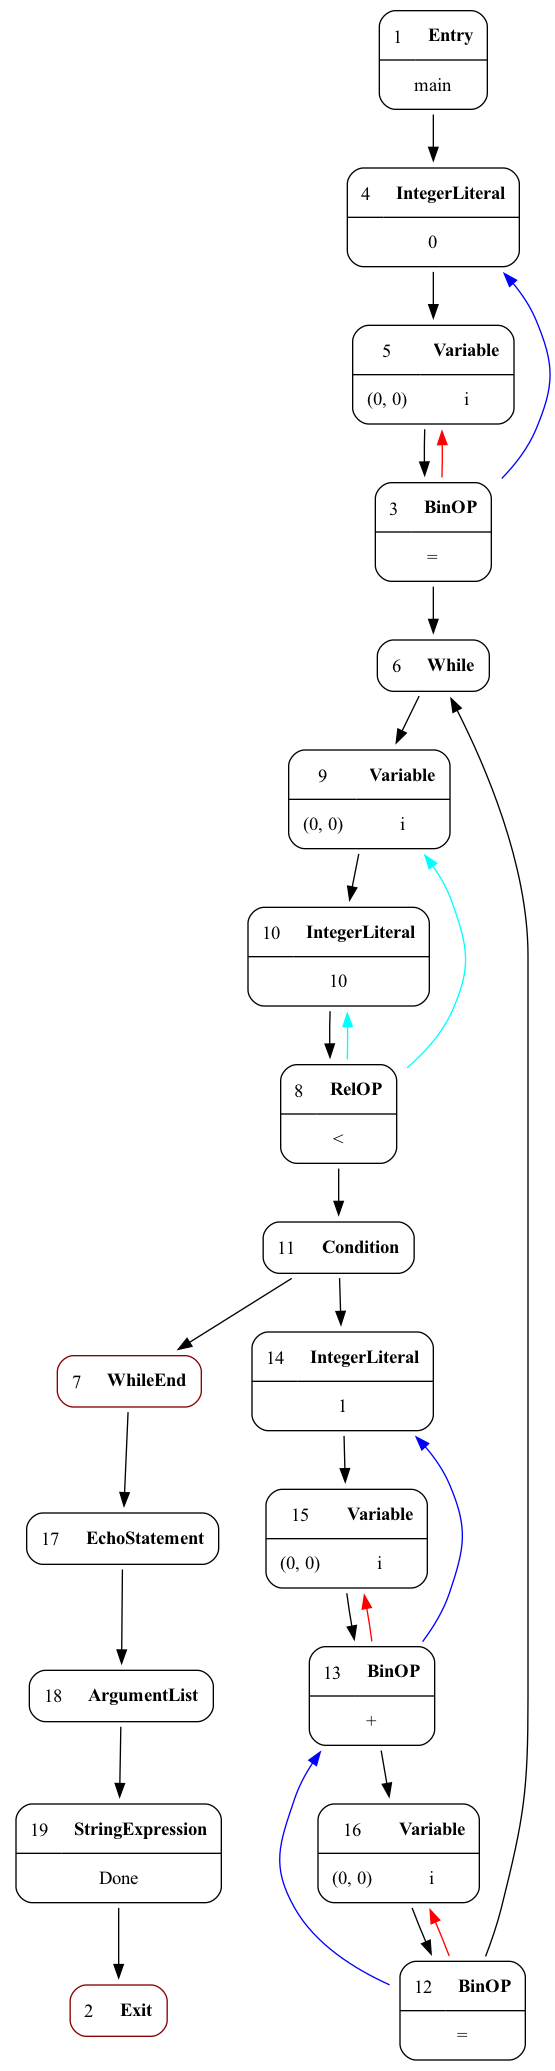

In [5]:
ast = ast_reader.read_ast("../part_1/while/while.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_graph(cfg)

## Exemple 4 - While, Continue, Break

Visit AST from file code.php
Generic visit for Html
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression


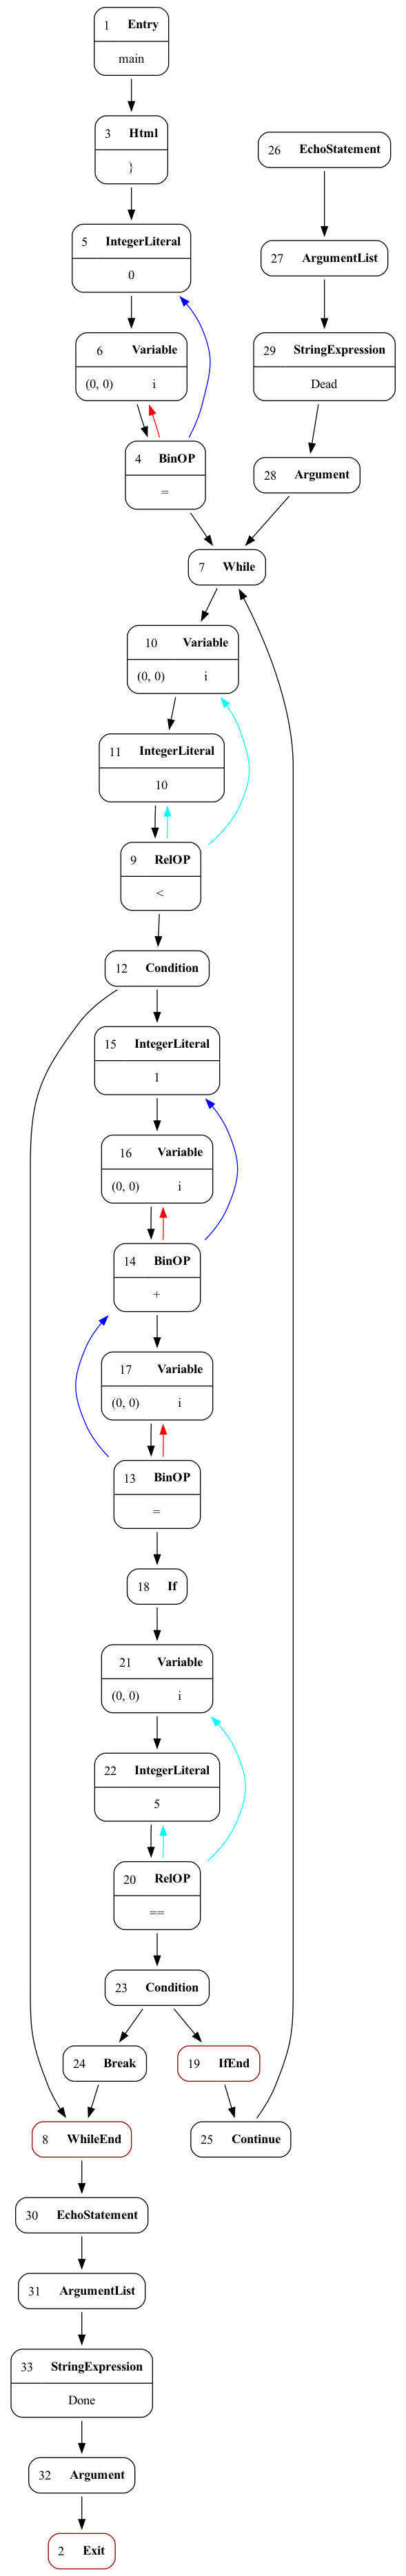

In [6]:
ast = ast_reader.read_ast("../part_1/while/while_continue_break.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_graph(cfg)

# 2. Code mort

La classe `IntraDeadCodeVisitor` utilise le CFG pour détecter le code mort intra-procédural.

Avant de commencer, le visiteur récupère tous les IDs des nodes du CFG (dans `invalid_ids`). Ensuite, à chaque node visitée, l'ID de cette node se supprime de l'ensemble (`set()`). Les IDs restants à la fin sont ceux qui n'ont pas été visités, et qui sont donc inatteignables dans le CFG.

Sur un CFG, le visiteur va s'exécuter sur l'entrée principale ainsi que sur l'entrée des fonctions.

In [7]:
class IntraDeadCodeVisitor:
    def __init__(self, cfg: CFG) -> None:
        self.cfg = cfg
        self.curr_nid = 0
        self.invalid_ids = set(cfg.get_node_ids())

        self.handlers = {
            "CallBegin": self.visit_call_begin,
            "IncludeBegin": self.visit_call_begin,
        }

    def get_new_nid(self) -> int:
        self.curr_nid += 1
        return self.curr_nid

    @classmethod
    def visit(cls, cfg: CFG):
        visitor = cls(cfg)
        visitor.visit_node(cfg.get_root())
        for nid in cfg.get_func_entry_nodes():
            visitor.visit_node(nid)
        visitor.show_dead_code()
        return visitor.invalid_ids

    def iter_children(self, cfg_nid: int) -> None:
        children = self.cfg.get_children(cfg_nid)
        for child_nid in children:
            self.visit_node(child_nid)

    def visit_node(self, cfg_nid: int) -> None:
        # We don't iterate over a child that is already visited
        if cfg_nid in self.invalid_ids:
            self.invalid_ids.remove(cfg_nid)
            node_type = self.cfg.get_type(cfg_nid)
            handler = self.handlers.get(node_type, self.visit_generic)
            return handler(cfg_nid)

    def visit_generic(self, cfg_nid: int) -> None:
        self.iter_children(cfg_nid)

    def visit_call_begin(self, cfg_nid: int) -> None:
        call_end = self.cfg.get_call_end(cfg_nid)
        self.visit_node(call_end)

    def show_dead_code(self) -> None:
        unreached_lines = set()
        for nid in self.invalid_ids:
            position = self.cfg.get_position(nid)
            if position is not None:
                unreached_lines.add(position[0])

        if unreached_lines:
            print(
                f"Potential intra dead code in file '{self.cfg.get_filename()}'\n"
                f"- Unreachable nodes: {self.invalid_ids}\n"
                f"- Unreachable lines: {sorted(list(unreached_lines))}"
            )

La classe `InterDeadCodeVisitor` utilise les AST pour détecter le code mort inter-procédural.

In [8]:
class InterDeadCodeVisitor:
    def __init__(self, *asts: AST) -> None:
        self.asts = asts
        self.statements = defaultdict[str, list[str]](list)
        self.calls = set[tuple[str, str]]()

    @classmethod
    def visit(cls, *asts: AST) -> dict[str, list[str]]:
        visitor = cls(*asts)
        visitor.visit_all()
        visitor.filter_dead_code()
        visitor.show_dead_code()
        return visitor.statements

    def visit_all(self):
        for ast in self.asts:
            self.visit_ast(ast)

    def visit_ast(self, ast: AST) -> None:
        root = ast.get_root()
        self.iter_children(ast, root)

    def iter_children(self, ast: AST, ast_nid: int):
        match ast.get_type(ast_nid):
            case "FunctionStatement":
                filename = ast.get_filename()
                func_name = ast.get_image(ast_nid)
                self.statements[func_name].append(filename)
            case "FunctionCall":
                filename = ast.get_filename()
                func_name = ast.get_image(ast_nid)
                self.calls.add((filename, func_name))

        for child_node in ast.get_children(ast_nid):
            self.iter_children(ast, child_node)

    def filter_dead_code(self):
        for _, func in self.calls:
            self.statements.pop(func, None)

    def show_dead_code(self) -> None:
        if self.statements:
            by_file = defaultdict[str, list[str]](list)
            for func, files in self.statements.items():
                for file in files:
                    by_file[file].append(func)
            for file, funcs in by_file.items():
                print(
                    f"Potential inter dead code in file '{file}'\n"
                    f"- Unreached functions: {funcs}"
                )

## Exemple 1

Potential intra dead code in file 'code.php'
- Unreachable nodes: {3, 9, 10, 11, 12}
- Unreachable lines: [6]


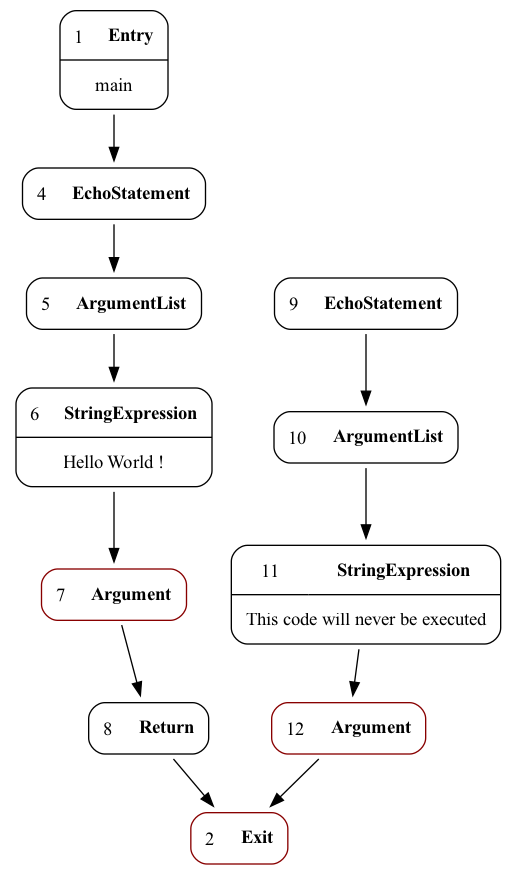

In [9]:
cfg = cfg_reader.read_cfg("../part_2/code_mort/example1.php.cfg.json")
IntraDeadCodeVisitor.visit(cfg)
show_graph(cfg)

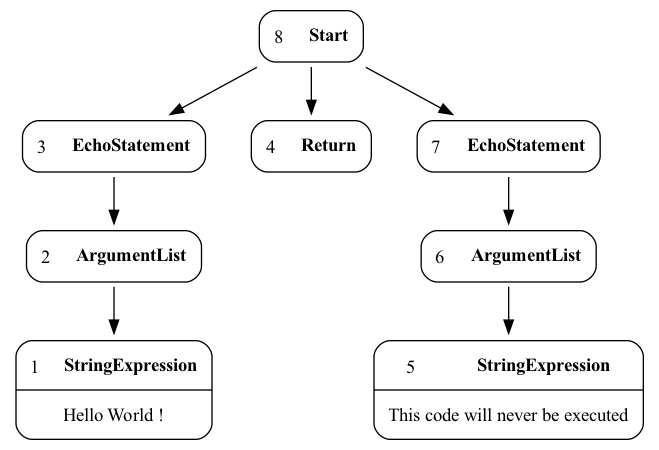

In [10]:
ast = ast_reader.read_ast("../part_2/code_mort/example1.php.ast.json")
InterDeadCodeVisitor.visit(ast)
show_graph(ast)

## Exemple 2

Potential intra dead code in file 'code.php'
- Unreachable nodes: {3, 5, 11, 12, 13, 14, 15, 16}
- Unreachable lines: [6, 9]


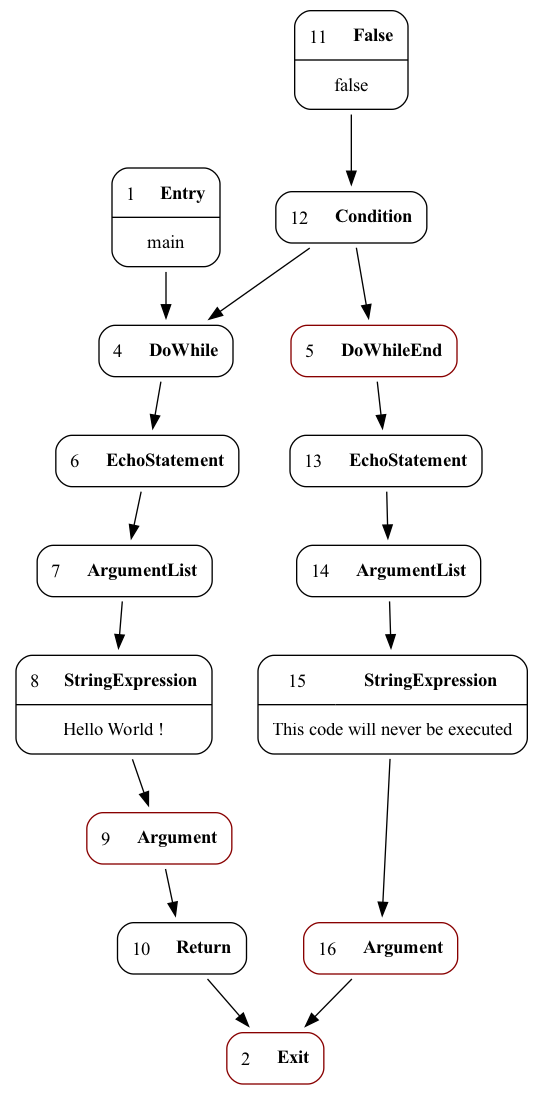

In [11]:
cfg = cfg_reader.read_cfg("../part_2/code_mort/example2.php.cfg.json")
IntraDeadCodeVisitor.visit(cfg)
show_graph(cfg)

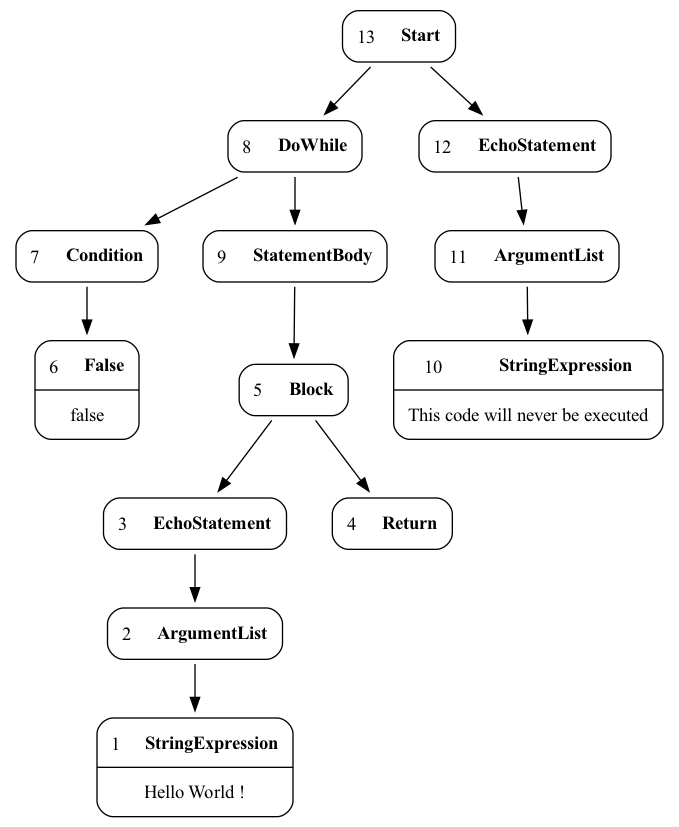

In [12]:
ast = ast_reader.read_ast("../part_2/code_mort/example2.php.ast.json")
InterDeadCodeVisitor.visit(ast)
show_graph(ast)

## Exemple 3

Potential intra dead code in file 'code.php'
- Unreachable nodes: {13, 14, 15, 16, 26, 36, 37, 38, 39}
- Unreachable lines: [6, 16]


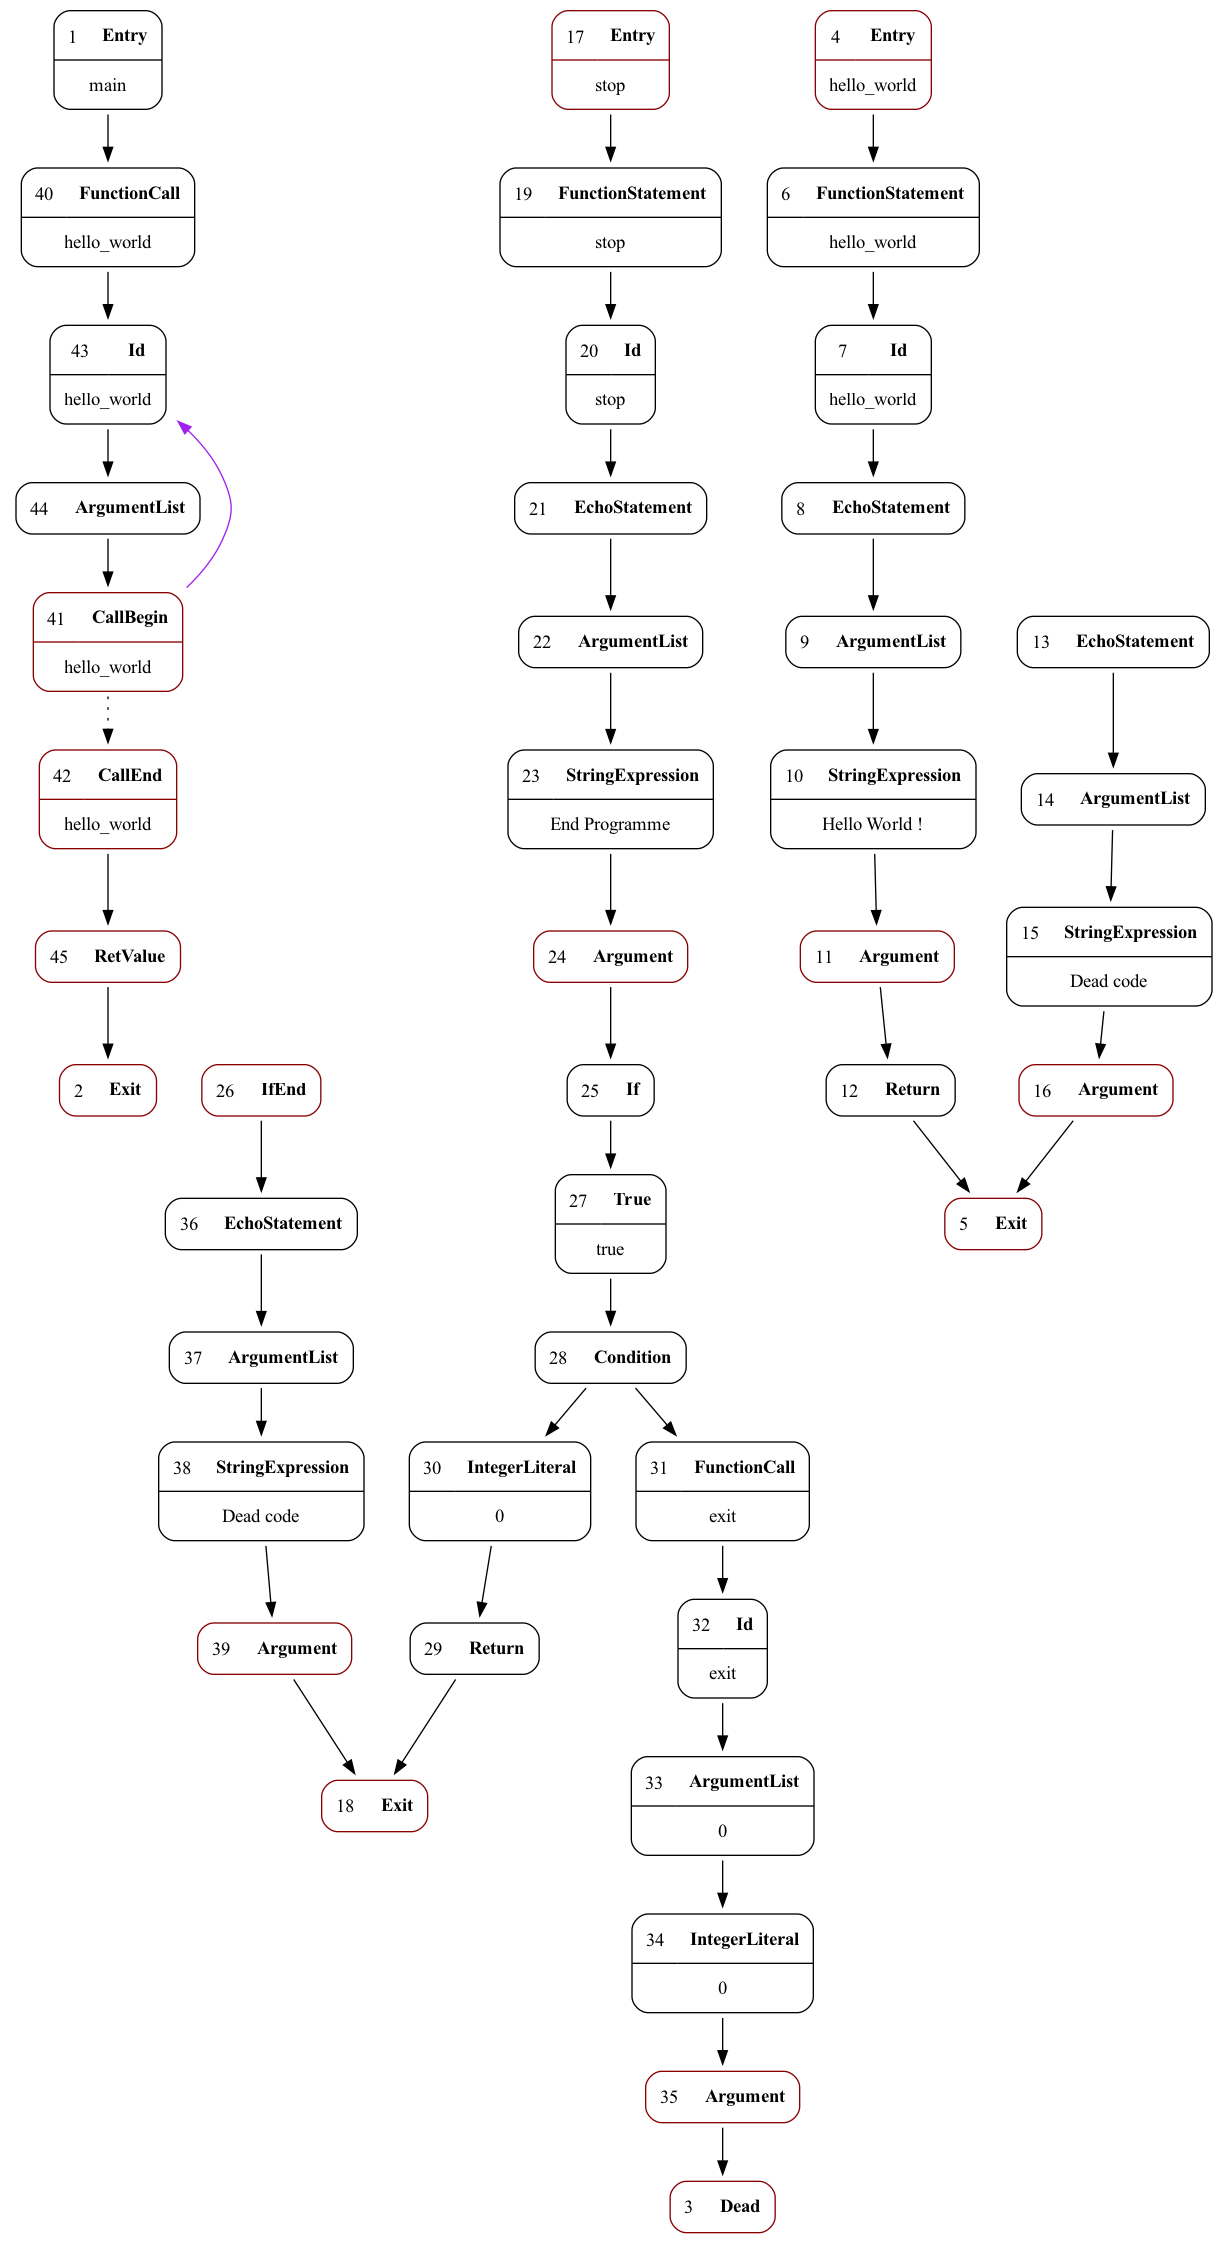

In [13]:
cfg = cfg_reader.read_cfg("../part_2/code_mort/example3.php.cfg.json")
IntraDeadCodeVisitor.visit(cfg)
show_graph(cfg)

Potential inter dead code in file 'code.php'
- Unreached functions: ['stop']


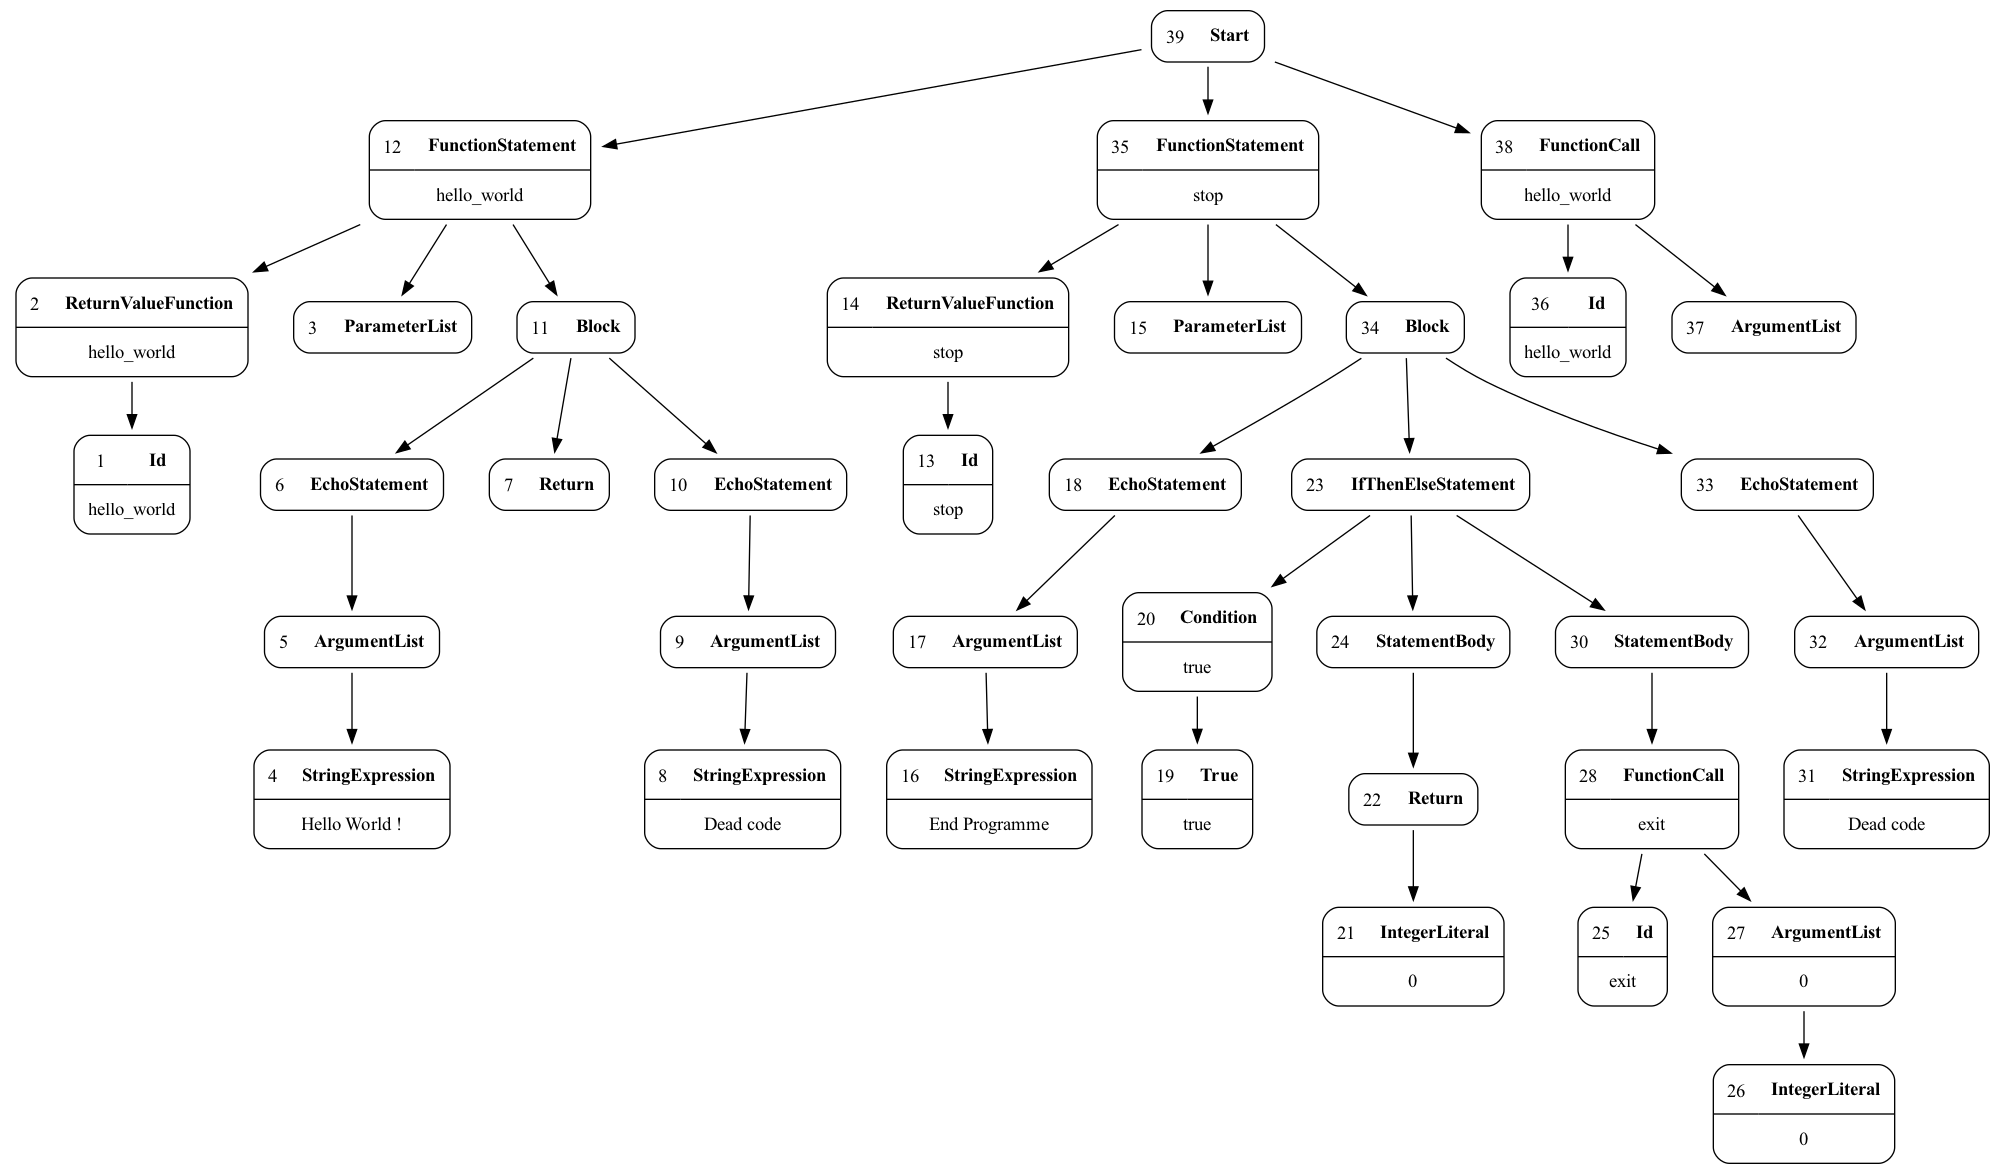

In [14]:
ast = ast_reader.read_ast("../part_2/code_mort/example3.php.ast.json")
InterDeadCodeVisitor.visit(ast)
show_graph(ast)

## Code WordPress

In [15]:
CODE_TO_ANALYZE_DIR = Path("../part_2/wordpress")
WP_AST_CFG_DIR = CODE_TO_ANALYZE_DIR / "wordpress_ast_cfg"

In [16]:
with (WP_AST_CFG_DIR / "filelist").open() as file:
    for line in file:
        cfg_path = WP_AST_CFG_DIR / line.strip()
        cfg = cfg_reader.read_cfg(cfg_path.as_posix())
        IntraDeadCodeVisitor.visit(cfg)

Potential intra dead code in file './wp-admin/credits.php'
- Unreachable nodes: {63488, 63489, 63490, 63491, 63492, 63493, 63494, 63495, 63496, 63497, 63498, 63499, 63500, 63501, 63502, 63503, 63504, 63505, 63506, 63507, 63508, 63509, 63510, 63511, 63512, 63513, 63514, 63515, 63516, 63517, 63518, 63519, 63520, 63521, 63522, 63523, 63524, 63525, 63526, 63527, 63528, 63529, 63530, 63531, 62791, 63452, 63453, 63454, 63455, 63456, 63457, 63458, 63459, 63460, 63461, 63462, 63463, 63464, 63465, 63466, 63467, 63468, 63469, 63470, 63471, 63472, 63473, 63474, 63475, 63476, 63477, 63478, 63479, 63480, 63481, 63482, 63483, 63484, 63485, 63486, 63487}
- Unreachable lines: [116, 117, 118, 119, 120, 121, 122, 123, 124, 125]
Potential intra dead code in file './wp-admin/setup-config.php'
- Unreachable nodes: {57913, 57914, 57915, 57916, 57917, 57918, 57919, 57920, 57921, 57922, 57923, 57924, 57925, 57926, 57927, 57928, 57929, 57930, 57931, 57932, 57933, 57934, 57935, 57936, 57937, 57938, 57939, 57940

In [17]:
all_asts = []

with (WP_AST_CFG_DIR / "filelist").open() as file:
    for line in file:
        ast_path = WP_AST_CFG_DIR / line.strip().replace(".cfg", ".ast")
        ast = ast_reader.read_ast(ast_path.as_posix())
        all_asts.append(ast)

_ = InterDeadCodeVisitor.visit(*all_asts)

Potential inter dead code in file './wp-signup.php'
- Unreached functions: ['do_signup_header', 'wpmu_signup_stylesheet']
Potential inter dead code in file './wp-content/plugins/akismet/class.akismet-widget.php'
- Unreached functions: ['akismet_register_widgets']
Potential inter dead code in file './wp-content/plugins/akismet/wrapper.php'
- Unreached functions: ['akismet_test_mode', 'akismet_http_post', 'akismet_microtime', 'akismet_delete_old', 'akismet_delete_old_metadata', 'akismet_check_db_comment', 'akismet_rightnow', 'akismet_admin_init', 'akismet_version_warning', 'akismet_load_js_and_css', 'akismet_nonce_field', 'akismet_plugin_action_links', 'akismet_conf', 'akismet_stats_display', 'akismet_stats', 'akismet_admin_warnings', 'akismet_comment_row_action', 'akismet_comment_status_meta_box', 'akismet_comments_columns', 'akismet_comment_column_row', 'akismet_text_add_link_callback', 'akismet_text_add_link_class', 'akismet_check_for_spam_button', 'akismet_submit_nonspam_comment', 'a